# dispatch_bench analysis notebook (F2)
_2024-04-11_

## Introduction

This notebook does dispatch loop analysis for palladium samurai traces.

This output is for S2 dispatch loops


In [11]:
# 1) configure with URL
# 2) Pull down log and any samurai files    
# 3) use the git tag to scrape the recent git commit history?
# 4) scrape the log for UUID
# 5) excat the debug symbols
# 6) generate the dasm and stitch it to the log
# 7) lookup the functions addresses we need
# 8) crack the log to find the functions we know about
# 9) isolate individual dispatch loop executions
# 10) put in a data set
# 11) bifurcate on prefetch, cost, etc. to various graphs
# 12) allow selection and display of a data set based on timestamp

# ~/fungible/src/FunTools/TraceParser/pc_trace_ba.py dasm.txt samurai/   
# /Users/Shared/cross/mips64/bin/mips64-unknown-elf-objdump -d funos-s2-emu > funos-s2-emu.dasm

# Carlos' job: http://palladium-jobs.fungible.local:8080/job/3578477

# JSON desc: http://palladium-jobs.fungible.local/api/job/3578477

# Raw files 'http://palladium-jobs.fungible.local/api/job/3578477/raw_file/odp/timeline.json'

#    cgray@server1:/demand/demand/Jobs/0000002a4hz3-24-07-02-10-28/rdp/F2_Compute/'samu*.gz' .
#    cgray@tanuki:~/fungible/dispatch_bench/f2/9280551 % scp cgray@server1:/demand/demand/Jobs/0000002a4hz3-24-07-02-10-28/rdp/F2_Compute/'*.gz' .

#    cgray@tanuki:~/fungible/dispatch_bench/f2/9280551 r=130 % excat.py get c9dad8cd-2b42-5c79-6eac-69f970c86376


#    ${SDKDIR}/bin/scripts/elf2dasm.py <elf> <dasm>

# annotate the trace files!

# ~/fungible/src/FunTools/TraceParser/pc_trace_ba.py <dasm> samurai/


In [12]:
# constants
from typing import Optional, Dict, Tuple, Sequence, List, Set, Callable, Any, Iterable, Union, TextIO
import os

LOOP_START: List[str] = ["$L_loop_start_sp", "$L_loop_start_s", "$L_loop_start_spb"]
TRACE_PATHS: List[Tuple[str, str]] = [
    #(2375059, "s2", "s2 spb?"),
    #(3578477, "f2", "f2-carlos"),
    (9600565, "f2", "f2 spb regression check"),
    #(9443234, "f2", "f2 suresh bench")
    (9353451, "f2", "f2 suresh bench2")
]
NVPS: int = 4

SDKDIR: str = os.path.expanduser("~/fungible/src/FunSDK")

In [13]:
from enum import Enum

"""
class GPRVal():
    vp: int
    reg: int
    value: str
    value_int: int
    def __init__(self, toks: List[str]) -> None:
        assert(toks[0] == "G")
        self.vp = int(toks[1])
        self.reg = int(toks[2])
        self.value = toks[3]
        self.value_int = int(self.value, 16)
"""

class Inst():
    vpnum: int
    addr: str
    addr_int: int
    inst_raw: int
    cycle: int
    time: str
    nscount: str
    label: Optional[str]
    asm: str
    instr: str
    def __init__(self, toks: List[str]) -> None:
        assert(toks[0] == "I")
        self.vpnum = int(toks[1])
        self.addr = toks[2]
        self.addr_int = int(self.addr, 16)
        self.inst_raw = int(toks[3], 16)
        assert(toks[5].startswith("Cycle="))
        self.cycle = int(toks[5][6:])
        self.time = toks[6]
        self.nscount = toks[7]

        if (toks[8].startswith("<") and toks[8].endswith(">:")):
            self.label = toks[8][1:-2]
            istart = 10
        else:
            self.label = None
            istart = 9

        self.asm = "\t".join(toks[istart:])
        self.instr = toks[istart]
        self.grad = None

    def columns()-> List[str]:
        return ["cycle", "addr", "label", "asm"]

    def to_row(self) -> Tuple[Any, ...]:
        label = self.label
        if (label is None):
            label = ""
        asm = self.asm.replace("\t", "    ")
        return (self.cycle, self.addr, label, asm)

"""
class VP():
    num: int
    state: str
    insts: List[Inst]
    def __init__(self, num: int):
        self.num = num
        self.state = "UNKNOWN"
        self.insts = []
    
    def add_instruction(self, inst: Inst):
        assert(inst.vp == self.num)
        self.insts.append(inst)
    
    def add_graduate(self, grad: Grad):
        # throw away if this is the first thing
        if (len(self.insts) == 0):
            return

        self.insts[-1].grad = grad
"""

def parse_instructions(fl: TextIO) -> List[Inst]:
    ilist: List[Inst] = []

    for line in fl.readlines():
        try:
            toks = line.split()
            
            if (toks[0] not in ["I", "G", "MF", "ML", "MH", "F"]):
                print(f"Ignoring unknown start token {toks[0]}")
                continue

            if (toks[0] != "I"):
                continue

            ilist.append(Inst(toks))

        except:
            print(f"fail on line {toks}")

    return ilist

# a single iteration of the dispatch loop
# accumulated here
class Dispatch():
    vpnum: int
    cycle: int
    key: str
    is_done: bool

    prev: Optional["Dispatch"]
    next: Optional["Dispatch"]

    before_ilist: List[Inst]
    wu_ilist: List[Inst]
    after_ilist: List[Inst]

    interf_set: Set[int]
    interf_count: int
    wuname: Optional[str]


    def __init__(self, vpnum:int, prev: Optional["Dispatch"]) -> None:
        # core state
        self.is_done = False
        self.vpnum = vpnum
        self.cycle = -1
        if (prev is not None):
            assert(prev.vpnum == self.vpnum)
        self.prev = prev
        if (self.prev is not None):
            self.prev.next = self

        # accumulated state
        self.before_ilist = []
        self.wu_ilist = []
        self.after_ilist = []
        self.interf_set = set()
        self.interf_count = 0
        self.wuname = None

    def done(self) -> None:
        assert (not self.is_done)
        self.cycle = self.before_ilist[0].cycle
        self.key = f"{self.cycle}[{self.vpnum}]"
        self.is_done = True

    ## dataframe row/column data for the dispatch as a whole
    def columns() -> List[str]:
        return ["key", "cycle", "vpnum", "wuname", "dispatch_cycles",
                "dispatch_inst", "wu_cycles", "wu_inst",
                "n_interf", "interf_count"]

    def to_row(self) -> Tuple[str, ...]:
        wu_cycles = self.wu_ilist[-1].cycle - self.wu_ilist[0].cycle
        wu_inst = len(self.wu_ilist)
        dispatch_cycles = self.after_ilist[-1].cycle - self.before_ilist[0].cycle - wu_cycles
        dispatch_inst = len(self.before_ilist) + len(self.after_ilist)
        return (self.key, self.cycle, self.vpnum, self.wuname,
                dispatch_cycles, dispatch_inst, wu_cycles, wu_inst,
                len(self.interf_set), self.interf_count)        

    ## dataframe row/column data for the dispatch instructions
    def to_inst_rows(self, include_wu: bool) -> List[Tuple[Any,...]]:
        rows = list(map(Inst.to_row, self.before_ilist))
        if (include_wu):
            rows += list(map(Inst.to_row, self.wu_ilist))
        else:
            #FIXME
            pass
        rows += list(map(Inst.to_row, self.after_ilist))

        return rows


# stateful parser for the instruction stream for a given
# vpnum.
PState = Enum("PState", ["unknown", "before_wu", "in_wu", "after_wu"])
class DispatchParser():

    # our vpnum
    vpnum: int

    ## current parsing state
    state: PState
    dispatch: Dispatch
    expected_ra: int

    ## accumulated state
    dlist: Dict[str, Dispatch]

    def __init__(self, vpnum: int) -> None:
        self.vpnum = vpnum
        self.dlist = {}        # pristine dispatches
        self.dlist_interf = {} # dispatches with interference
        self.dlist_error = {}  # dispatches with errors (eg dropped instructions)
        self.prev_dispatch = None
        self.clean_pstate(None, PState.unknown)

    def clean_pstate(self, prev: Optional[Dispatch], state: PState = PState.before_wu) -> None:
        self.dispatch = Dispatch(self.vpnum, prev)
        self.state = state
        self.expected_ra = -1

    def _precheck_inst(self, inst: Inst) -> bool:
        if (inst.vpnum != self.vpnum):
            self.dispatch.interf_set.add(inst.vpnum)
            self.dispatch.interf_count += 1
            return False

        return True

    def _dispatch_done(self, inst: Inst, error: bool) -> None:
        # start the next iteration
        self.dispatch.done()

        # put in the good list or the interference list
        if (error):
            dlist = self.dlist_error
        elif (self.dispatch.interf_count == 0):
            dlist = self.dlist
        else:
            dlist = self.dlist_interf
        dlist[self.dispatch.key] = self.dispatch
        
        self.clean_pstate(self.dispatch)
        self.dispatch.before_ilist.append(inst)


    def _add_instruction_unknown(self, inst: Inst) -> None:
        # ignore anyting not ours
        if (inst.vpnum != self.vpnum):
            return
        
        # ignore anything other than the start of the loop
        if (inst.label not in LOOP_START):
            return

        self.dispatch.before_ilist.append(inst)
        self.state = PState.before_wu

    def _add_instruction_before_wu(self, inst: Inst) -> None:
        if (not self._precheck_inst(inst)):
            return

        self.dispatch.before_ilist.append(inst)
        if (inst.label in LOOP_START):
            print(f"Unexpected loop start on vp {self.vpnum}: {inst.cycle} -- {inst.asm}")
            print(f"Dropping dispatch with {len(self.dispatch.before_ilist)} instructions")
            self._dispatch_done(inst, True)
            return

        # this is the indirect branch
        if (inst.instr == "jalrc"):
            self.expected_ra = inst.addr_int + 4
            self.state = PState.in_wu


    def _add_instruction_wu(self, inst: Inst) -> None:
        if (not self._precheck_inst(inst)):
            return

        # this is the returned-to instruction
        if (inst.addr_int == self.expected_ra):
            self.state = PState.after_wu
            self.dispatch.after_ilist.append(inst)
            return
        
        self.dispatch.wu_ilist.append(inst)

        if (self.dispatch.wuname is None and inst.label is not None):
            self.dispatch.wuname = inst.label

    def _add_instruction_after_wu(self, inst: Inst) -> None:
        if (not self._precheck_inst(inst)):
            return

        # always add the instruction to the end
        self.dispatch.after_ilist.append(inst)

        if (inst.label in LOOP_START):
            self._dispatch_done(inst, False)        



    # state demux for adding an instruction
    # "inst" can be on any VP, so must be filtered in the callee
    def add_instruction(self, inst: Inst) -> None:        
        if (self.state == PState.unknown):
            self._add_instruction_unknown(inst)
        elif (self.state == PState.before_wu):
            self._add_instruction_before_wu(inst)
        elif (self.state == PState.in_wu):
            self._add_instruction_wu(inst)
        elif (self.state == PState.after_wu):
            self._add_instruction_after_wu(inst)
        else:
            raise RuntimeError("unknown state")

    def done(self) -> Dict[str, Dispatch]:
        # kill the incomplete dispatch to be sure
        self.dispatch = Dispatch(-1, None)
        return self.dlist



#
def find_dispatches(ilist: List[Inst]) -> (Dict[str, Dispatch], int, int):
    d: Dict[str, Dispatch] = {}

    # make the tuple of parsers
    parsers = tuple([DispatchParser(i) for i in range(NVPS)])

    # map each instruction on to each parser
    for inst in ilist:
        for parser in parsers:
            parser.add_instruction(inst)

    # get the full list of dispatches
    ninterf = 0
    nerr = 0
    for parser in parsers:
        d.update(parser.done())
        ninterf += len(parser.dlist_interf)
        nerr += len(parser.dlist_error)

    return (d, ninterf, nerr)


def file_has_dispatches(fl: TextIO):
    for line in fl.readlines():
        for start in LOOP_START:
            if start in line:
                return True
            
    return False


###
##  job download helpers
#

def do_download(url, fname):
    print(f"Trying to download {url}")

    if (fname[:-3] == ".gz"):
        headers = {"Accept-Encoding": "gzip"}
    else:
        headers = {}

    # download url to filename
    response = requests.get(url, headers=headers)

    print(f"Got response {response.status_code}, content type {response.headers['content-type']}, length {len(response.content)}")

    # make sure we have the path of `fname` in existence
    os.makedirs(os.path.dirname(fname), exist_ok=True)

    with open(fname, 'wb') as file:
        file.write(response.content)


    print(f"done")

def parse_nop(fname):
    if (os.path.exists(fname)):
        return True

def ensure_job_file(localfile: str, download_fn, parse_fn = parse_nop) -> Any:

    # try and parse a cached copy
    if (not os.path.exists(localfile)):
        print(f"Could not fine local file {localfile}, fetching")
    else:
        try:
            print(f"Parsing file {localfile} {os.path.exists(localfile)}")
            ret = parse_fn(localfile)
            print(f"Parsed file {ret}")
            if (ret is not None):
                # return if we got it
                return ret
            else:
                print(f"Parse function returned None, fetching")
        except:
            print(f"Error parsing existing file {localfile}, fetching")


    # if we made it here, we need to download a new copy
    download_fn(localfile)

    # now parse it
    ret = parse_fn(localfile)

    if (ret is None):
        raise(RuntimeError(f"Parsing {localfile} returned None"))

    return ret

def ensure_job_files(fdesc, fglob, allfiles, download_fn) -> List[str]:

    # just check if we have the files
    flist = glob.glob(fglob)
    if (len(flist) > 0):
        print(f"Found existing {fdesc} files, using them")
        return flist

    print(f"Failed to find any {fdesc} files, downloading...")

    # if we don't, run the downloads
    for fname in allfiles:
        print(f"Attempting to download f{fname}")
        download_fn(fname)

    # now retry the glob
    flist = glob.glob(fglob)

    if (len(flist) == 0):
        raise RuntimeError(f"Failed to download any {fdesc} files")

    print(f"Downloaded {fdesc} files {flist}")
    return flist

def ensure_processed_file(src, dest, converter):
    if (not os.path.exists(src)):
        raise RuntimeError(f"cannot proceed without {src}")

    if (os.path.exists(dest)):
        print(f"File {dest} exists, using that")
        return

    # actually process the file
    print(f"Processed file {dest} does not exist, generating from {src}")
    converter(src, dest)

    if (not os.path.exists(dest)):
        raise RuntimeError(f"Converter function failed to generate {dest}")

# parse the uart log for information
RE_UUID = r""
RE_DEBUG = f"FIXME"
def parse_log_file(fname: str) -> Dict[str, Any]:
    fl = open(fname)
    for line in fl.readlines():
        line = line.strip()
        if (not "[kernel] Build ID=" in line):
            continue

        # just take the last chars
        NUUIDCHARS = 16 * 2 + 4
        uuidstr = line[-NUUIDCHARS:]

        # just return it for now
        d = {"uuid": uuidstr}
        print(f"Parsed log uuid {uuidstr}")
        return d

    print("Failed to parse log file")
    return None


def excat_get(uuid, fname):

    cmd = [f"{SDKDIR}/bin/scripts/excat.py", "get", uuid]
    print(cmd)
    filedir = subprocess.check_output(cmd)
    filedir = filedir.strip()
    print(f"excat file is {filedir}")
    if not os.path.exists(filedir):
        raise RuntimeError("Couldn't find excat output")

    # move the file where it belongs
    shutil.move(filedir, fname)

def load_json_by_name(fname):

    fl = open(fname)
    return json.load(fl)

def elf2dasm(src, dest):    
    e2d = os.path.join(SDKDIR, "bin", "scripts", "elf2dasm.py")
    cmd = [e2d, src, dest]
    print(cmd)
    subprocess.call(cmd)

def samurai_download(jobid, hwmodel, localdir, remote):
    # get the gz
    url = f"http://palladium-jobs.fungible.local/api/job/{jobid}/raw_file/rdp/{hwmodel}/{remote}.gz"
    localfile = os.path.join(localdir, f"{remote}.gz")

    print(f"Downloading {url} to {localfile}")
    do_download(url, localfile)

    # unzip the gz
    cmd = ["gunzip", localfile]
    subprocess.call(cmd)


## Trace Parsing Log

In [15]:
import pandas as pd
import glob
import os
import json
import subprocess
import requests
import shutil
from IPython.display import Markdown

class Result:
    # setup
    desc: str
    trace_path: str
    dispatches: Dict[str, Dispatch]

    # table data
    dispatch_tab: Any # table of dispatches, dataframe
    irows: List[Tuple[str, Any]] # list of (key, instruction rows)
    sample_ex: Any # sample execution, dataframe
    per_cycle: Any # cycle-by-cycle breakdown, dataframe
    max_ipc: int # maximum IPC seen in this result

    def __init__(self, desc, trace_path, dispatches):
        self.desc = desc
        self.trace_path = trace_path
        self.dispatches = dispatches
        self.irows = []

    def num_rows(self):
        return len(self.dispatches)


# search the jobinfo for the funos basename. sigh.
def find_funos_basename(jobinfo):
    bo = jobinfo["basic_outputs"]
    for node in bo:
        if node[0] != "FunOS Console":
            continue

        return node[1]["basename"]

    raise RuntimeError("Couldn't find FunOS basename")

results: Dict[str, Result] = {}

# loop over all the inputs
for (jobid, bucket, desc) in TRACE_PATHS:

    ## compute the job path
    jobpath = os.path.join(bucket, str(jobid))
    samurai_path = os.path.join(jobpath, "samurai")

    # Just see if we have some trace file
    tglob = os.path.join(samurai_path, "trace.*")

    print(f"Looking for existing traces for run {jobid} {desc}")
    tfiles = glob.glob(tglob)

    if (len(tfiles) > 0):
        print(f"Using existing trace files {tfiles}")
    else:
        print(f"Failed to find any existing trace files ({tglob}, trying to download & generate)")

        ## load the job json
        jobjs = os.path.join(jobpath, "job.json")
        url = f"http://palladium-jobs.fungible.local/api/job/{jobid}"
        dlfn = lambda lf: do_download(url, lf)
        jobinfo = ensure_job_file(jobjs, dlfn, load_json_by_name)

        ## make sure we have the UART log
        uartlog = os.path.join(jobpath, "cdn_uartout0.txt")
        #url = f"http://palladium-jobs.fungible.local/api/job/{jobid}/raw_file/odp/cdn_uartout0.txt"
        funoslog = find_funos_basename(jobinfo)
        url = f"http://palladium-jobs.fungible.local/api/job/{jobid}/raw_file/{funoslog}"
        dlfn = lambda lf: do_download(url, lf)
        loginfo = ensure_job_file(uartlog, dlfn, parse_log_file)

        ## make sure we have the ELF file
        uuid = loginfo['uuid']
        elf = os.path.join(jobpath, f"{uuid}.excat")
        dlfn = lambda lf: excat_get(uuid, lf)
        ensure_job_file(elf, dlfn)

        ## make sure we have the dasm
        dasm = elf + ".dasm"
        ensure_processed_file(elf, dasm, elf2dasm)

        ## download any traces that may exist
        ## assuming if we have one, that was all there is
        samurai_glob = os.path.join(samurai_path, "*.trace")
        samurai_all = [f"samurai_core{c}_{o}.trace" for c in range(0,9) for o in range(0,6)]
        dlfn = lambda remote: samurai_download(jobid, jobinfo["job_dict"]["hardware_model"],
                        os.path.join(jobpath, "samurai"), remote)
        samurai_files = ensure_job_files("samurai", samurai_glob, samurai_all, dlfn)

        # run "pc_trace_ba" to convert the unpacked samurai files into
        # dasm annotated "trace.{c}{o}" files
        pctba = os.path.join(SDKDIR, "..", "FunTools", "TraceParser", "pc_trace_ba.py")

        if samurai_path[-1] != "/":
            samurai_path += "/"
        cmd = [pctba, dasm, samurai_path]
        print(f"Generating trace files with {cmd}")
        subprocess.call(cmd)

        ## finally parse the trace files
        print(f"Looking for newly generated traces for run {jobid} {desc}")
        tfiles = glob.glob(tglob)

    if (len(tfiles) == 0):
        raise RuntimeError(f"Could not find/generate trace files for ({desc}, {tglob})")
    
    dispatches: Dict[str, Dispatch] = {}

    for fname in tfiles:
        # quickly scan each file to see if it has dispatches
        fl = open(fname)
        ilist: List[Inst] = []

        if (not file_has_dispatches(fl)):
            print(f"Ignoring file without dispatches {fname}")
            continue

        print(f"Parsing trace file {fname}")

        # now do the full parsing
        fl.seek(0)
        ilist = parse_instructions(fl)

        print(f"Found total {len(ilist)} instructions in {fname}")

        fd: Dict[str, Dispatch]
        ninterf: int
        (fd, ninterf, nerr) = find_dispatches(ilist)

        print(f"Found {len(fd)} dispatch iterations ({ninterf} with interference, {nerr} with errors)")

        dispatches.update(fd)


    if (len(dispatches) == 0):
        raise RuntimeError(f"No dispatches for ({desc}, {tglob})")

    results[desc] = Result(desc=desc, trace_path=samurai_path,
                           dispatches=dispatches)
    print("")

print("All trace files parsed")

Looking for existing traces for run 9600565 f2 spb regression check
Failed to find any existing trace files (f2/9600565/samurai/trace.*, trying to download & generate)
Parsing file f2/9600565/job.json True
Parsed file {'basic_outputs': [['SBP Console', {'basename': 'odp/cdn_uartout1.txt', 'exists': True, 'line_count': None, 'modified': 1720399081.5157938, 'path': '/demand/demand/Jobs/000000tbxx65-24-07-07-17-10/odp/cdn_uartout1.txt', 'size': 71, 'type': 'text'}], ['FunOS Console', {'basename': 'odp/cdn_uartout0.txt', 'exists': True, 'line_count': None, 'modified': 1720402440.0296273, 'path': '/demand/demand/Jobs/000000tbxx65-24-07-07-17-10/odp/cdn_uartout0.txt', 'size': 39639, 'type': 'text'}]], 'bld_props': {'bldNum': '151714', 'devLine': 'master', 'dochubComponents': [{'name': 'cc-linux-yocto', 'number': '953', 'skipChangeLog': 'true'}], 'docker': {'jenkins/bld_funos': 'sha256:a8a06f3a8ac667d999267d941055991a2084fd2a7199032c338cbab359f3f9ca'}, 'fileVersion': '1.1', 'gitHubSha1s': {'F

gunzip: f2/9600565/samurai/samurai_core0_0.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core0_2.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core0_2.trace.gz


gunzip: f2/9600565/samurai/samurai_core0_1.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core0_3.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core0_3.trace.gz


gunzip: f2/9600565/samurai/samurai_core0_2.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core0_4.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core0_4.trace.gz


gunzip: f2/9600565/samurai/samurai_core0_3.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core0_5.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core0_5.trace.gz


gunzip: f2/9600565/samurai/samurai_core0_4.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core1_0.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core1_0.trace.gz


gunzip: f2/9600565/samurai/samurai_core0_5.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core1_1.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core1_1.trace.gz


gunzip: f2/9600565/samurai/samurai_core1_0.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core1_2.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core1_2.trace.gz


gunzip: f2/9600565/samurai/samurai_core1_1.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core1_3.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core1_3.trace.gz


gunzip: f2/9600565/samurai/samurai_core1_2.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core1_4.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core1_4.trace.gz


gunzip: f2/9600565/samurai/samurai_core1_3.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core1_5.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core1_5.trace.gz


gunzip: f2/9600565/samurai/samurai_core1_4.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core2_0.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core2_0.trace.gz


gunzip: f2/9600565/samurai/samurai_core1_5.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core2_1.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core2_1.trace.gz


gunzip: f2/9600565/samurai/samurai_core2_0.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core2_2.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core2_2.trace.gz


gunzip: f2/9600565/samurai/samurai_core2_1.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core2_3.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core2_3.trace.gz


gunzip: f2/9600565/samurai/samurai_core2_2.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core2_4.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core2_4.trace.gz


gunzip: f2/9600565/samurai/samurai_core2_3.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core2_5.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core2_5.trace.gz


gunzip: f2/9600565/samurai/samurai_core2_4.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core3_0.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core3_0.trace.gz


gunzip: f2/9600565/samurai/samurai_core2_5.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core3_1.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core3_1.trace.gz


gunzip: f2/9600565/samurai/samurai_core3_0.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core3_2.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core3_2.trace.gz


gunzip: f2/9600565/samurai/samurai_core3_1.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core3_3.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core3_3.trace.gz


gunzip: f2/9600565/samurai/samurai_core3_2.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core3_4.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core3_4.trace.gz


gunzip: f2/9600565/samurai/samurai_core3_3.trace.gz: not in gzip format


Got response 200, content type text/plain, length 10983524
done
Attempting to download fsamurai_core3_5.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core3_5.trace.gz


gunzip: f2/9600565/samurai/samurai_core3_4.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core4_0.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core4_0.trace.gz


gunzip: f2/9600565/samurai/samurai_core3_5.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core4_1.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core4_1.trace.gz


gunzip: f2/9600565/samurai/samurai_core4_0.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core4_2.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core4_2.trace.gz


gunzip: f2/9600565/samurai/samurai_core4_1.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core4_3.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core4_3.trace.gz


gunzip: f2/9600565/samurai/samurai_core4_2.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core4_4.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core4_4.trace.gz


gunzip: f2/9600565/samurai/samurai_core4_3.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core4_5.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core4_5.trace.gz


gunzip: f2/9600565/samurai/samurai_core4_4.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core5_0.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core5_0.trace.gz


gunzip: f2/9600565/samurai/samurai_core4_5.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core5_1.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core5_1.trace.gz


gunzip: f2/9600565/samurai/samurai_core5_0.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core5_2.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core5_2.trace.gz


gunzip: f2/9600565/samurai/samurai_core5_1.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core5_3.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core5_3.trace.gz


gunzip: f2/9600565/samurai/samurai_core5_2.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core5_4.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core5_4.trace.gz


gunzip: f2/9600565/samurai/samurai_core5_3.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core5_5.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core5_5.trace.gz


gunzip: f2/9600565/samurai/samurai_core5_4.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core6_0.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core6_0.trace.gz


gunzip: f2/9600565/samurai/samurai_core5_5.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core6_1.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core6_1.trace.gz


gunzip: f2/9600565/samurai/samurai_core6_0.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core6_2.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core6_2.trace.gz


gunzip: f2/9600565/samurai/samurai_core6_1.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core6_3.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core6_3.trace.gz


gunzip: f2/9600565/samurai/samurai_core6_2.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core6_4.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core6_4.trace.gz


gunzip: f2/9600565/samurai/samurai_core6_3.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core6_5.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core6_5.trace.gz


gunzip: f2/9600565/samurai/samurai_core6_4.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core7_0.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core7_0.trace.gz


gunzip: f2/9600565/samurai/samurai_core6_5.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core7_1.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core7_1.trace.gz


gunzip: f2/9600565/samurai/samurai_core7_0.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core7_2.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core7_2.trace.gz


gunzip: f2/9600565/samurai/samurai_core7_1.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core7_3.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core7_3.trace.gz


gunzip: f2/9600565/samurai/samurai_core7_2.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core7_4.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core7_4.trace.gz


gunzip: f2/9600565/samurai/samurai_core7_3.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core7_5.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core7_5.trace.gz


gunzip: f2/9600565/samurai/samurai_core7_4.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core8_0.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core8_0.trace.gz


gunzip: f2/9600565/samurai/samurai_core7_5.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core8_1.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core8_1.trace.gz


gunzip: f2/9600565/samurai/samurai_core8_0.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core8_2.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core8_2.trace.gz


gunzip: f2/9600565/samurai/samurai_core8_1.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core8_3.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core8_3.trace.gz


gunzip: f2/9600565/samurai/samurai_core8_2.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core8_4.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core8_4.trace.gz


gunzip: f2/9600565/samurai/samurai_core8_3.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done
Attempting to download fsamurai_core8_5.trace
Trying to download http://palladium-jobs.fungible.local/api/job/9600565/raw_file/rdp/F2_Compute/samurai_core8_5.trace.gz


gunzip: f2/9600565/samurai/samurai_core8_4.trace.gz: not in gzip format


Got response 404, content type application/json, length 65
done


gunzip: f2/9600565/samurai/samurai_core8_5.trace.gz: not in gzip format


RuntimeError: Failed to download any samurai files

## Summary of all the dispatch iterations for each run

Column Descriptions:

 * **wuname**: The name of the WU that was dispatched
 * **dispatch_cycles**: The number of cycles for the dispatch loop execution
 * **dispatch_inst**: The number of instructions for the dispatch loop execution
 * **wu_cycles**: Number of cycles spent in the WU handler
 * **wu_inst**: Number of instructions in the WU handler
 * **n_interf**: Number of other VPs that ran during execution of this dispatch iteration
 * **interf_count**: Number of instructions from other VPs during execution of this dispatch iteration

# f2 spb regression check has 504 dispatch iterations:

### mean: 53.0

### median: 53.0

### std: 0.0

,key,cycle,vpnum,wuname,dispatch_cycles,dispatch_inst,wu_cycles,wu_inst,n_interf,interf_count
0,213057375[0],213057375,0,dispatch_bench_nop,53,36,0,1,0,0
1,213057428[0],213057428,0,dispatch_bench_nop,53,36,0,1,0,0
2,213057481[0],213057481,0,dispatch_bench_nop,53,36,0,1,0,0
3,213057534[0],213057534,0,dispatch_bench_nop,53,36,0,1,0,0
4,213057587[0],213057587,0,dispatch_bench_nop,53,36,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
499,213083822[0],213083822,0,dispatch_bench_nop,53,36,0,1,0,0
500,213083875[0],213083875,0,dispatch_bench_nop,53,36,0,1,0,0
501,213083928[0],213083928,0,dispatch_bench_nop,53,36,0,1,0,0
502,213083981[0],213083981,0,dispatch_bench_nop,53,36,0,1,0,0


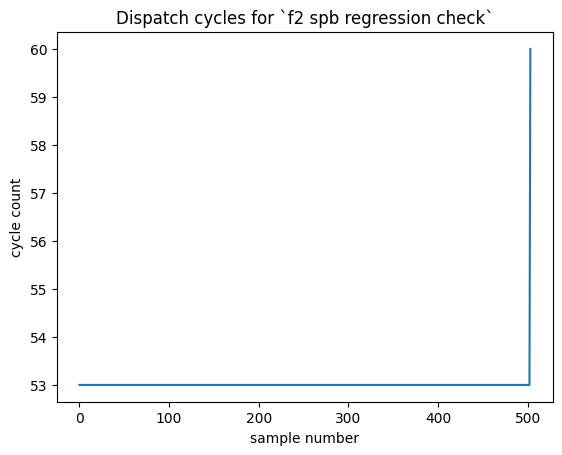

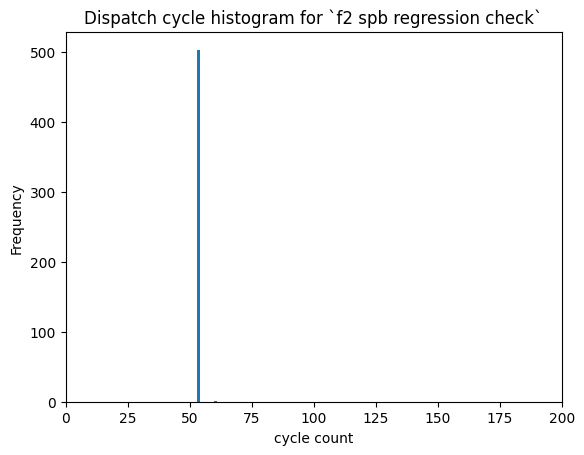

# f2 suresh bench2 has 404 dispatch iterations:

### mean: 84.18159203980099

### median: 82.0

### std: 8.357317008692256

,key,cycle,vpnum,wuname,dispatch_cycles,dispatch_inst,wu_cycles,wu_inst,n_interf,interf_count
0,783306662[0],783306662,0,epcq_fun_rqbuf_cqe_eth_with_cqe,91,36,527,394,0,0
1,783307280[0],783307280,0,wuh_idle,79,36,574,212,0,0
2,783307933[0],783307933,0,epcq_fun_rqbuf_cqe_eth_with_cqe,80,36,311,280,0,0
3,783323044[0],783323044,0,epcq_intr_timer,97,36,34,31,0,0
4,783323175[0],783323175,0,wuh_idle,81,36,1035,212,0,0
...,...,...,...,...,...,...,...,...,...,...
399,783372362[3],783372362,3,wuh_idle,79,36,829,220,0,0
400,783373270[3],783373270,3,fwd_process_fae_resp_hu,79,36,427,299,0,0
401,783444836[3],783444836,3,fwd_process_fae_resp_hu,82,36,464,299,0,0
402,783445382[3],783445382,3,wuh_idle,80,36,1000,216,0,0


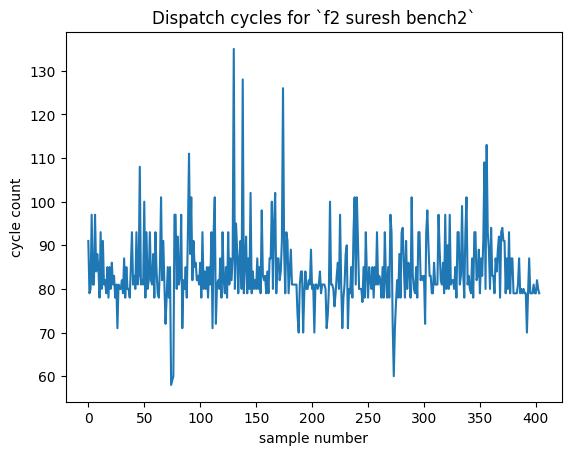

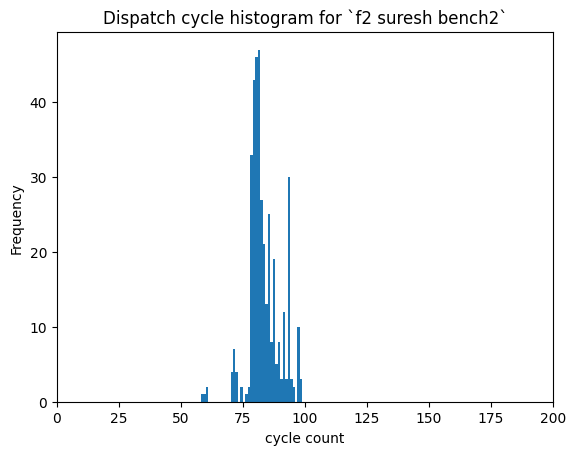

In [8]:
import matplotlib.pyplot as plt

k: str
r: Result
for (k, r) in results.items():
    display(Markdown(f"# {k} has {r.num_rows()} dispatch iterations:"))

    # now make a dataframe from them all
    rows: List[Tuple[str, ...]] = []
    for dispatch in r.dispatches.values():
        rows.append(dispatch.to_row())
    r.dispatch_tab = pd.DataFrame(rows, columns=Dispatch.columns())
    r.dispatch_tab.style.set_caption(f"Dispatch Table {k}")

    display(Markdown(f"### mean: {r.dispatch_tab['dispatch_cycles'][1:-1].mean()}"))
    display(Markdown(f"### median: {r.dispatch_tab['dispatch_cycles'][1:-1].median()}"))
    display(Markdown(f"### std: {r.dispatch_tab['dispatch_cycles'][1:-1].std()}"))

    display(r.dispatch_tab)
    r.dispatch_tab["dispatch_cycles"].plot(title=f"Dispatch cycles for `{k}`")
    plt.ylabel("cycle count")
    plt.xlabel("sample number")

    # force the graph to render
    plt.show()

    # plot the histogram of "dispatch_cycles" column
    # nbins = r.num_rows()
    nbins = range(0,100)
    r.dispatch_tab["dispatch_cycles"].plot.hist(bins=nbins,
                                        xlim=(0, 200),
                                        xlabel="dispatch cycles",
                                        title=f"Dispatch cycle histogram for `{k}`")
    plt.xlabel("cycle count")
    # force the graph to render
    plt.show()


## Sample execution of the dispatch loop for each run

In [9]:
k: str
r: Result
for (k, r) in results.items():
        no = r.num_rows()
        n = no - 2 # account for first and last
        p0_i = 0
        p75_i = int(0.75 * n)
        p99_i = int(0.99 * n)

        tab = r.dispatch_tab[1:-1]

        # sort by cycle number
        tab = tab.sort_values("dispatch_cycles", ignore_index=True)

        # display(tab)

        iters = [(p0_i, "best"), (p75_i, "p75"), (p99_i, "p99")]
        for (p_i, p_s) in iters:                
                # lookup the dispatch iteration we want
                KEY: str = tab["key"].iloc[p_i]
                disp: Dispatch = r.dispatches[KEY]

                display(Markdown(f"# {k}: Using key {KEY} at {p_s} ({p_i})"))

                # create a df from it
                irows = disp.to_inst_rows(True)
                r.irows.append((p_s, irows))
                sample_ex = pd.DataFrame(irows, columns=Inst.columns())

                r.sample_ex = sample_ex

                # add a row for cycle delta
                #df2["cycle delta"] = df2["cycle"].diff().fillna(0).astype(int)
                r.sample_ex.insert(0, "cycle delta", r.sample_ex["cycle"].diff().fillna(0).astype(int))

                display(Markdown(f'### Total Cost: {r.sample_ex["cycle"].iloc[-1] - r.sample_ex["cycle"][0]}'))
                display(Markdown(f'### Max latency: {r.sample_ex["cycle delta"].describe().max()}'))

                r.sample_ex = r.sample_ex.style.set_properties(**{'text-align': 'left'})

                # display it
                display(r.sample_ex)



# f2 spb regression check: Using key 213057428[0] at best (0)

### Total Cost: 53

### Max latency: 37.0

,cycle delta,cycle,addr,label,asm
0,0,213057428,a800000000101ae4,$L_loop_start_spb,"ld a4,960(s0)"
1,1,213057429,a800000000101ae8,,"ld t0,968(s0)"
2,1,213057430,a800000000101aec,,"ld a5,976(s0)"
3,0,213057430,a800000000101af0,,"ld t1,984(s0)"
4,1,213057431,a800000000101af4,,"ld a6,992(s0)"
5,0,213057431,a800000000101af8,,"ld t2,1000(s0)"
6,1,213057432,a800000000101afc,,"pref 0x0,0(a4)"
7,1,213057433,a800000000101b00,,"pref 0x0,0(t0)"
8,1,213057434,a800000000101b04,,"pref 0x0,0(a5)"
9,1,213057435,a800000000101b08,,"pref 0x0,0(t1)"


# f2 spb regression check: Using key 213064000[0] at p75 (376)

### Total Cost: 53

### Max latency: 37.0

,cycle delta,cycle,addr,label,asm
0,0,213064000,a800000000101ae4,$L_loop_start_spb,"ld a4,960(s0)"
1,1,213064001,a800000000101ae8,,"ld t0,968(s0)"
2,1,213064002,a800000000101aec,,"ld a5,976(s0)"
3,0,213064002,a800000000101af0,,"ld t1,984(s0)"
4,1,213064003,a800000000101af4,,"ld a6,992(s0)"
5,0,213064003,a800000000101af8,,"ld t2,1000(s0)"
6,1,213064004,a800000000101afc,,"pref 0x0,0(a4)"
7,1,213064005,a800000000101b00,,"pref 0x0,0(t0)"
8,1,213064006,a800000000101b04,,"pref 0x0,0(a5)"
9,1,213064007,a800000000101b08,,"pref 0x0,0(t1)"


# f2 spb regression check: Using key 213065961[0] at p99 (496)

### Total Cost: 53

### Max latency: 37.0

,cycle delta,cycle,addr,label,asm
0,0,213065961,a800000000101ae4,$L_loop_start_spb,"ld a4,960(s0)"
1,1,213065962,a800000000101ae8,,"ld t0,968(s0)"
2,1,213065963,a800000000101aec,,"ld a5,976(s0)"
3,0,213065963,a800000000101af0,,"ld t1,984(s0)"
4,1,213065964,a800000000101af4,,"ld a6,992(s0)"
5,0,213065964,a800000000101af8,,"ld t2,1000(s0)"
6,1,213065965,a800000000101afc,,"pref 0x0,0(a4)"
7,1,213065966,a800000000101b00,,"pref 0x0,0(t0)"
8,1,213065967,a800000000101b04,,"pref 0x0,0(a5)"
9,1,213065968,a800000000101b08,,"pref 0x0,0(t1)"


# f2 suresh bench2: Using key 783589720[1] at best (0)

### Total Cost: 88

### Max latency: 81.0

,cycle delta,cycle,addr,label,asm
0,0,783589720,a800000000100fec,$L_loop_start_spb,"ld a4,960(s0)"
1,0,783589720,a800000000100ff0,,"ld t0,968(s0)"
2,1,783589721,a800000000100ff4,,"ld a5,976(s0)"
3,0,783589721,a800000000100ff8,,"ld t1,984(s0)"
4,1,783589722,a800000000100ffc,,"ld a6,992(s0)"
5,0,783589722,a800000000101000,,"ld t2,1000(s0)"
6,1,783589723,a800000000101004,,"pref 0x0,0(a4)"
7,1,783589724,a800000000101008,,"pref 0x0,0(t0)"
8,1,783589725,a80000000010100c,,"pref 0x0,0(a5)"
9,1,783589726,a800000000101010,,"pref 0x0,0(t1)"


# f2 suresh bench2: Using key 783400227[1] at p75 (301)

### Total Cost: 191

### Max latency: 114.0

,cycle delta,cycle,addr,label,asm
0,0,783400227,a800000000100fec,$L_loop_start_spb,"ld a4,960(s0)"
1,1,783400228,a800000000100ff0,,"ld t0,968(s0)"
2,1,783400229,a800000000100ff4,,"ld a5,976(s0)"
3,0,783400229,a800000000100ff8,,"ld t1,984(s0)"
4,1,783400230,a800000000100ffc,,"ld a6,992(s0)"
5,0,783400230,a800000000101000,,"ld t2,1000(s0)"
6,8,783400238,a800000000101004,,"pref 0x0,0(a4)"
7,1,783400239,a800000000101008,,"pref 0x0,0(t0)"
8,4,783400243,a80000000010100c,,"pref 0x0,0(a5)"
9,1,783400244,a800000000101010,,"pref 0x0,0(t1)"


# f2 suresh bench2: Using key 783364992[3] at p99 (397)

### Total Cost: 351

### Max latency: 241.0

,cycle delta,cycle,addr,label,asm
0,0,783364992,a800000000100fec,$L_loop_start_spb,"ld a4,960(s0)"
1,1,783364993,a800000000100ff0,,"ld t0,968(s0)"
2,1,783364994,a800000000100ff4,,"ld a5,976(s0)"
3,0,783364994,a800000000100ff8,,"ld t1,984(s0)"
4,1,783364995,a800000000100ffc,,"ld a6,992(s0)"
5,0,783364995,a800000000101000,,"ld t2,1000(s0)"
6,8,783365003,a800000000101004,,"pref 0x0,0(a4)"
7,1,783365004,a800000000101008,,"pref 0x0,0(t0)"
8,1,783365005,a80000000010100c,,"pref 0x0,0(a5)"
9,1,783365006,a800000000101010,,"pref 0x0,0(t1)"


# Cycle-by-cycle execution of each run

In [10]:
k: str
r: Result

for (krun, r) in results.items():
    for (krows, irows) in r.irows:
        # convert irows to a per-cycle dict
        k0 = irows[0][0]
        kn = irows[-1][0]

        d = {}
        for k in range(kn - k0 + 1):
            d[k0+k] = []

        for irow in irows:
            if (irow[2] != ""):
                d[irow[0]].append(f"{irow[2]}: {irow[3]}")
            else:
                d[irow[0]].append(f"        {irow[3]}")

        r.maxipc = max(list(map(len, d.values())))

        crows = []
        for (k, v) in d.items():
            t = (k, )
            t += tuple(v)
            t += tuple(("", ) * (r.maxipc - len(v)))
            crows.append(t)

        r.per_cycle = pd.DataFrame(crows, columns=["cycle abs", "i0", "i1"])

        display(Markdown(f"# Per-cycle execution for {krun} -- {krows}"))
        with pd.option_context("display.max_rows", None):
            display(r.per_cycle)


# Per-cycle execution for f2 spb regression check -- best

,cycle abs,i0,i1
0,213057428,"$L_loop_start_spb: ld a4,960(s0)",
1,213057429,"ld t0,968(s0)",
2,213057430,"ld a5,976(s0)","ld t1,984(s0)"
3,213057431,"ld a6,992(s0)","ld t2,1000(s0)"
4,213057432,"pref 0x0,0(a4)",
5,213057433,"pref 0x0,0(t0)",
6,213057434,"pref 0x0,0(a5)",
7,213057435,"pref 0x0,0(t1)",
8,213057436,"pref 0x0,0(a6)",
9,213057437,"ld a3,1280(s0)","ld a0,1288(s0)"


# Per-cycle execution for f2 spb regression check -- p75

,cycle abs,i0,i1
0,213064000,"$L_loop_start_spb: ld a4,960(s0)",
1,213064001,"ld t0,968(s0)",
2,213064002,"ld a5,976(s0)","ld t1,984(s0)"
3,213064003,"ld a6,992(s0)","ld t2,1000(s0)"
4,213064004,"pref 0x0,0(a4)",
5,213064005,"pref 0x0,0(t0)",
6,213064006,"pref 0x0,0(a5)",
7,213064007,"pref 0x0,0(t1)",
8,213064008,"pref 0x0,0(a6)",
9,213064009,"ld a3,1280(s0)","ld a0,1288(s0)"


# Per-cycle execution for f2 spb regression check -- p99

,cycle abs,i0,i1
0,213065961,"$L_loop_start_spb: ld a4,960(s0)",
1,213065962,"ld t0,968(s0)",
2,213065963,"ld a5,976(s0)","ld t1,984(s0)"
3,213065964,"ld a6,992(s0)","ld t2,1000(s0)"
4,213065965,"pref 0x0,0(a4)",
5,213065966,"pref 0x0,0(t0)",
6,213065967,"pref 0x0,0(a5)",
7,213065968,"pref 0x0,0(t1)",
8,213065969,"pref 0x0,0(a6)",
9,213065970,"ld a3,1280(s0)","ld a0,1288(s0)"


# Per-cycle execution for f2 suresh bench2 -- best

,cycle abs,i0,i1
0,783589720,"$L_loop_start_spb: ld a4,960(s0)","ld t0,968(s0)"
1,783589721,"ld a5,976(s0)","ld t1,984(s0)"
2,783589722,"ld a6,992(s0)","ld t2,1000(s0)"
3,783589723,"pref 0x0,0(a4)",
4,783589724,"pref 0x0,0(t0)",
5,783589725,"pref 0x0,0(a5)",
6,783589726,"pref 0x0,0(t1)",
7,783589727,"pref 0x0,0(a6)",
8,783589728,"ld a3,1280(s0)",
9,783589729,"ld a0,1288(s0)",


# Per-cycle execution for f2 suresh bench2 -- p75

,cycle abs,i0,i1
0,783400227,"$L_loop_start_spb: ld a4,960(s0)",
1,783400228,"ld t0,968(s0)",
2,783400229,"ld a5,976(s0)","ld t1,984(s0)"
3,783400230,"ld a6,992(s0)","ld t2,1000(s0)"
4,783400231,,
5,783400232,,
6,783400233,,
7,783400234,,
8,783400235,,
9,783400236,,


# Per-cycle execution for f2 suresh bench2 -- p99

,cycle abs,i0,i1
0,783364992,"$L_loop_start_spb: ld a4,960(s0)",
1,783364993,"ld t0,968(s0)",
2,783364994,"ld a5,976(s0)","ld t1,984(s0)"
3,783364995,"ld a6,992(s0)","ld t2,1000(s0)"
4,783364996,,
5,783364997,,
6,783364998,,
7,783364999,,
8,783365000,,
9,783365001,,
